# TP2 - Linear Regression - Different OLS models
___

##### File naming

In [266]:
fn1 = "bourhan"
ln1 = "dernayka"
filename = "_".join(map(lambda s: s.strip().lower(), [
                    "SD-TSIA204_lab2", ln1, fn1])) + ".ipynb"
print(filename)

sd-tsia204_lab2_dernayka_bourhan.ipynb


___
## 0 - Settings

In [623]:
colors = {'#d73027', '#fc8d59', '#fee090', '#91bfdb', '#4575b4'}
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from scipy.linalg import svd
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV

from scipy.stats import norm, t


import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1, style="whitegrid")
sns.set_palette(colors)                 # option 1
sns.set_palette(CB_color_cycle)         # option 2
sns.set_color_codes('colorblind')       # option 3 (currently selected)
sns.color_palette("colorblind")

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

___
## 1- Process the data
#### first point:

In [588]:
data = pd.read_csv("data_tp_2.csv", usecols=all)
data.head()

,X76,X95,X52,X36,X74,X69,X23,X27,X19,X39,...,X45,X67,X16,X37,X56,X35,X87,X89,X96,Y
0,-0.208298,0.793446,-0.200865,-0.005766,-0.336092,0.037238,0.148319,-1.423624,-0.411594,0.541975,...,-0.216825,0.552672,0.499400,0.134669,-1.639742,-0.004640,-0.635006,-0.758949,0.488324,24.0
1,-0.221028,-0.363311,-0.631604,1.152664,-0.532182,1.176513,-0.100142,1.170051,0.360931,0.593115,...,0.571930,-0.186832,-0.238081,1.404931,0.489104,0.248675,0.361039,0.435418,-1.324025,21.6
2,-1.059124,-0.777557,-0.172609,0.767116,0.141027,0.677921,0.820292,-0.255193,0.691621,0.254366,...,-0.643929,-0.543850,-0.478493,-0.386637,0.175114,-0.658092,-0.338583,-0.177981,-0.050339,34.7
3,1.133450,-0.790638,-0.586627,0.942378,0.283674,-0.577118,-0.145977,-0.263209,1.435926,-0.750034,...,0.719154,0.056236,-0.495367,0.204324,-1.078683,0.640999,-0.921276,-0.602238,0.421393,33.4
4,0.908181,-0.913293,0.362265,-0.437131,0.514517,-1.625222,1.019997,-0.422887,0.140903,-0.073760,...,1.026587,-0.230706,0.151710,-0.638937,0.072631,-0.517829,-1.028707,0.465484,0.351005,36.2


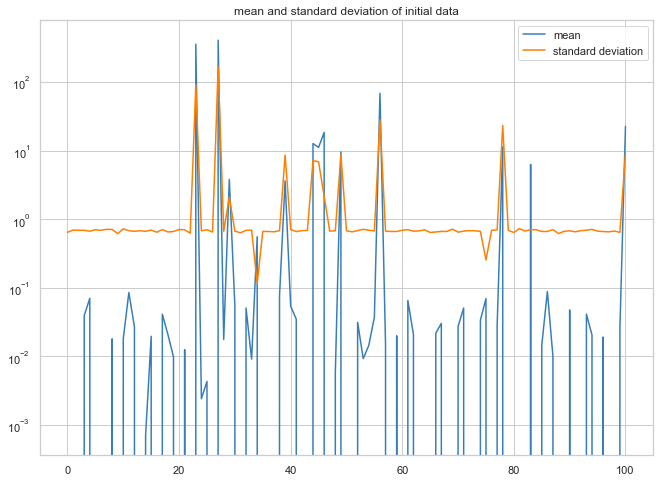

In [589]:
plt.figure(figsize=(11, 8))
plt.title("mean and standard deviation of initial data")
plt.yscale('log')
plt.plot(data[:-1].values.mean(axis=0))
plt.plot(data[:-1].values.std(axis=0))
_ = plt.legend(["mean", "standard deviation"])

In [590]:
sum(data[:-1].mean() < 1), sum(data[:-1].std() < 1)

(89, 90)

    We note that most of the data is close to being centered, 89 covariates out of 100 have a mean lesser than 1.
    Also, 90 covariates have standard deviations of less than 1.
    Hence, The data is not centered, nor normalized, nor standardized (centered + normalized).

#### second point:

In [591]:
X = data.iloc[:, :-1]; X_matrix = X.to_numpy()  # X_matrix is the matrix representation of the data frame. Hence, it has no titles
y = data.iloc[:, -1]; y_matrix = y.to_numpy()

n, p = X_matrix.shape

#### third point:

In [592]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0)

    We split the data into train and test sets, one fourth of the data is for testing.
    
    Note: removing the random_state parameter will generate different data partition on each run. However I opted to keep the same data partition throughout this study.

#### fourth point:

    We standarize our data using the StandardScaler() method 'fit_transform' :

In [593]:
X_train_matrix_fitted = StandardScaler().fit_transform(X_train)
X_test_matrix_fitted = StandardScaler().fit_transform(X_test)

    In fact this is equivalent to doing it by hand: (small error difference comparing to the fit_transform method)

In [594]:
X_train_fitted = (X_train - np.mean(X_train))/np.std(X_train)
X_test_fitted = (X_test - np.mean(X_test)) / np.std(X_test)

In [595]:
print("total difference is", sum(
    sum(np.array(X_train_fitted-X_train_matrix_fitted))))

total difference is 7.0992893977232276e-12


We can see that this is indeed a negligible error.

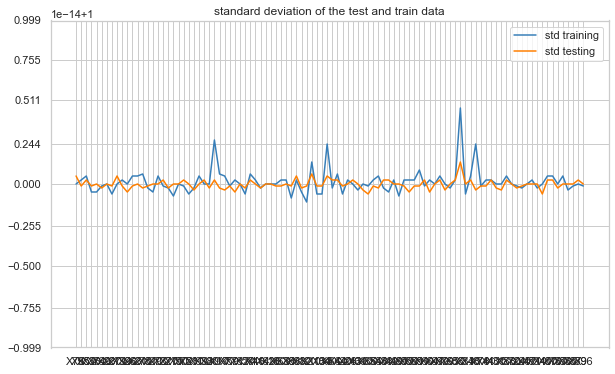

In [596]:
plt.figure(figsize=(10, 6))
plt.ylim((1 - 1e-14, 1 + 1e-14))
plot = plt.plot(X_train_fitted.columns, np.std(X_train_fitted),
                X_test_fitted.columns, np.std(X_test_fitted))
plt.legend(["std training", "std testing"])
_ = plt.title("standard deviation of the test and train data")

    We clearly see how it is revolving around 1 to the order e-14
    Now lets add the mean values too:

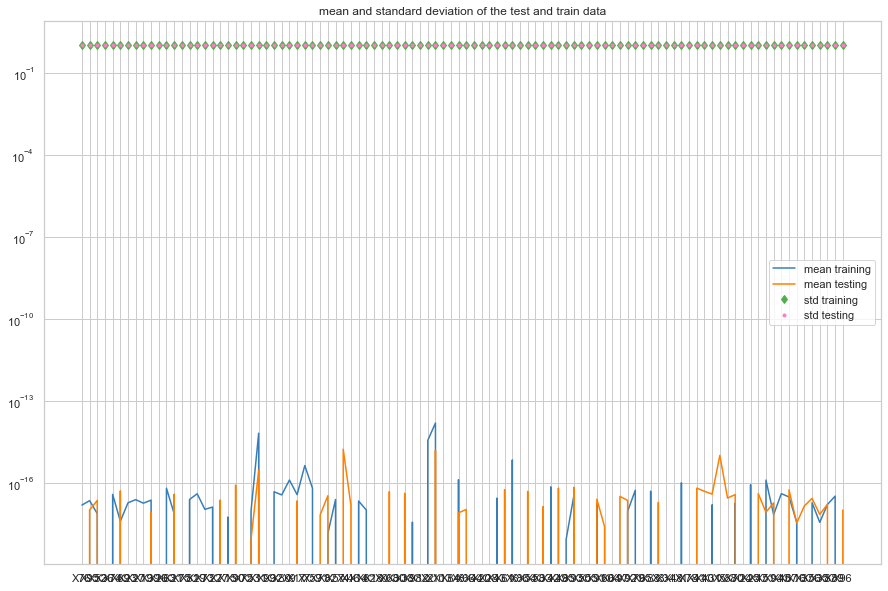

In [597]:
plt.figure(figsize=(15, 10))
plt.yscale('log')
plot = plt.plot(X_train_fitted.columns, X_train_fitted.mean(), 
                X_test_fitted.columns, X_test_fitted.mean())
plot = plt.plot(X_train_fitted.columns, X_train_fitted.std(), 'd',
                X_test_fitted.columns, X_test_fitted.std(), '.')

plt.legend(["mean training", "mean testing", "std training", "std testing"])
_ = plt.title("mean and standard deviation of the test and train data")

#### fifth point:

    We note that after standardizing the data, the mean is equal to 0 and the standard deviation equals 1 both in the order of 1e-14.
    
    Standardizing data is very important in the procedure of comparing different covariates that vary in range, amplitude or change rate. 
    In fact, it makes them all based on the same scale in order to have a meaningful covariation when comparing them together. In addition, this improves the LASSO method in particular, since it requires the presence of small, centered covariates in order to yield better answers.
    Actually, when computing the lambda parameters of the LASSO, their amplitudes depend on the amplitude of the variables they are multiplying. 
    Hence, smaller variables improve the minimization that the LASSO method tries to achieve.

#### sixth point:

In [702]:
df_test = pd.DataFrame()
df_coef = pd.DataFrame()

___
### 2- Functions to compute the determination coefficient and the mean squared error.

In [703]:
def det_coef(y, y_pred):
    """
        params: y is the actual (real measure) output value vector
                y_pred is the prediction output of our model
        return: the determination coefficient of our model if dimensions match 
    """
    if y.shape != y_pred.shape:
        raise ValueError('dimension mismatch')
    y_mean = y.mean()
    # original implementation:
    # return np.sum(np.power(y_pred - y_mean, 2)) / np.sum(np.power(y - y_mean, 2))
    # another more meaningful implementation will be :
    return 1 - np.sum(np.power(y - y_pred, 2)) / np.sum(np.power(y - y_mean, 2)) 


def MSE(y, y_pred):
    """
        params: y is the actual output value vector
                y_pred is the prediction output of our model
        return: the Mean Squarred Error of our model if dimensions match 
    """
    if y.shape != y_pred.shape:
        raise ValueError('dimension mismatch')
    n = y.shape[0]
    return np.sum(np.power(y - y_pred, 2))/n

___
### 3- Fit a linear regression model on the train set.

#### first point

In [704]:
lin_reg = linear_model.LinearRegression(fit_intercept=True)
lin_reg.fit(X_train_matrix_fitted, y_train)

LinearRegression()

In [705]:
# extra:
y_pred = lin_reg.predict(X_train_matrix_fitted)
print('Determination coefficient on train data (using my function) R^2 =', det_coef(y_train, y_pred))
print('VERIFICATION: Determination coefficient on train data (using linea_model) R^2 = {:.6f}\n'.format(
    lin_reg.score(X_train_matrix_fitted, y_train)))

if det_coef(y_train, y_pred) == lin_reg.score(X_train_matrix_fitted, y_train):
    print ("values match")
else:
    print("values doean't match")

Determination coefficient on train data (using my function) R^2 = 0.8298513403333554
VERIFICATION: Determination coefficient on train data (using linea_model) R^2 = 0.829851

values match


#### second point

In [706]:
y_pred = lin_reg.predict(X_test_matrix_fitted)
print('Determination coefficient on test data (using my function) R^2 =', det_coef(y_test, y_pred))
print("The Mean Squared Error on the test data is MSE =", MSE(y_test, y_pred))

print('\nVERIFICATION: Determination coefficient on test data (using linea_model) R^2 = {:.6f}\n'.format(
    lin_reg.score(X_test_matrix_fitted, y_test)))

Determination coefficient on test data (using my function) R^2 = 0.5384852478771162
The Mean Squared Error on the test data is MSE = 37.705300858566474

VERIFICATION: Determination coefficient on test data (using linea_model) R^2 = 0.538485



In [707]:
pd.DataFrame({'Actual': y_test, 'OLS_Predicted': y_pred})

,Actual,OLS_Predicted
329,22.6,24.447577
371,50.0,24.219346
219,23.0,29.791327
403,8.3,11.284968
78,21.2,17.628549
...,...,...
49,19.4,20.223273
498,21.2,21.164997
309,20.3,21.715490
124,18.8,17.119596


In [708]:
print("The intercept of our model here is approximately equal to the averge of our output y:",lin_reg.intercept_)
print("""This is because the model should always pass by the point (X_mean, Y_mean)
    which happens to be here (0, Y_mean) because we centered the data.
Hence the conclusion.""")

The intercept of our model here is approximately equal to the averge of our output y: 22.608707124010564
This is because the model should always pass by the point (X_mean, Y_mean)
    which happens to be here (0, Y_mean) because we centered the data.
Hence the conclusion.


#### third point

In [709]:
df_test["OLS"] = y_pred

#### forth  point

In [710]:
df_coef["OLS"] = [lin_reg.intercept_] + list(lin_reg.coef_)

___
### 4- Covariation Heatmap. SVD decomposition.

In [711]:
cov_mat = np.cov(X_train_fitted.T)

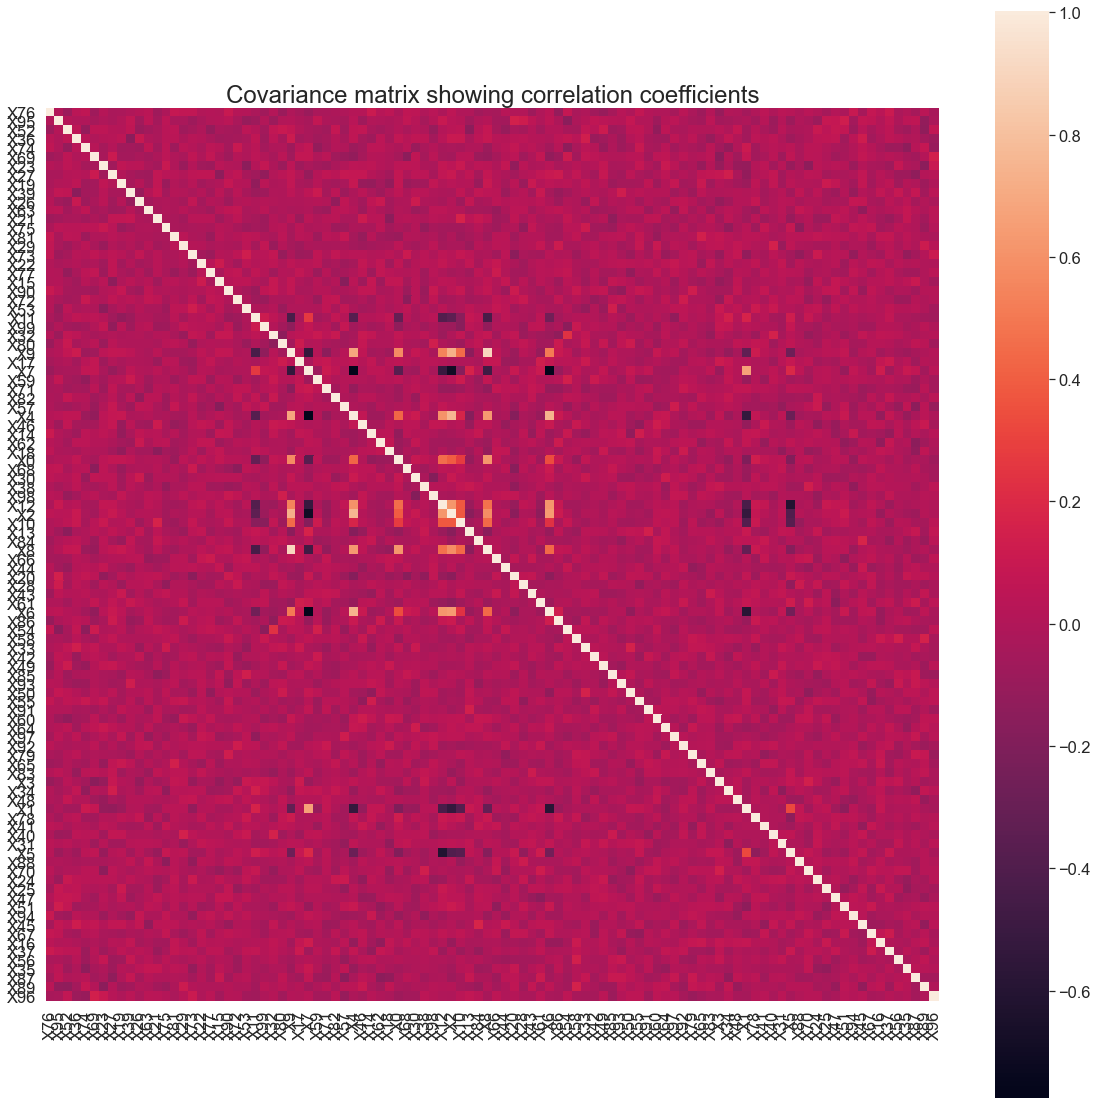

In [712]:
plt.figure(figsize=(20, 20))
sns.set(font_scale=1.5)
hm = sns.heatmap(cov_mat,
                 cbar=True,
                 annot=False,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 12},
                 yticklabels=X_train_fitted.columns,
                 xticklabels=X_train_fitted.columns)
sns.set_color_codes('colorblind')
sns.set(font_scale=2, style="whitegrid")
plt.title('Covariance matrix showing correlation coefficients')
plt.show()

In [713]:
#extra:
colsNb = X_train_fitted.columns
h = np.cov(X_train_fitted.T)
covs = dict()
for i in range(100):
    for j in range(i):
        if h[i][j] > 0.5 and i != j:
            covs[(colsNb[i], colsNb[j])] = h[i][j]
print("The most correlated covariates are:")
covs

The most correlated covariates are:


{('X4', 'X9'): 0.6887370714664898,
 ('X0', 'X9'): 0.5729657667808414,
 ('X12', 'X9'): 0.5423968956962054,
 ('X12', 'X4'): 0.601194892688427,
 ('X2', 'X9'): 0.731163013511906,
 ('X2', 'X4'): 0.7577069805119137,
 ('X2', 'X12'): 0.6185337380631449,
 ('X8', 'X9'): 0.9047715376552353,
 ('X8', 'X4'): 0.6303902984649972,
 ('X8', 'X0'): 0.6204535497566127,
 ('X8', 'X2'): 0.5802019505596807,
 ('X6', 'X9'): 0.5094958934638059,
 ('X6', 'X4'): 0.7454911890067448,
 ('X6', 'X12'): 0.6174299797299896,
 ('X6', 'X2'): 0.6368817954842396,
 ('X1', 'X7'): 0.6624575160495887}

    Here is the Singular Vaule Decomposition of the covariations matrix:

In [714]:
cov_mat = np.cov(X_train_fitted.T)
U, s, V = svd(cov_mat)

___
### 5- Primary Component Analysis

In [715]:
U_reduced = U[:, :2]             # first two eigenvectors corresponding to the biggest 2 eigenvalues
S = np.eye(U.shape[0])*s         # diagonal matrix of the eigenvalues
Us = U.dot(S)                    # the Principal Component projection of our data
Us_reduced = Us[:, :2]           # the reduced dimension of the projection matrix

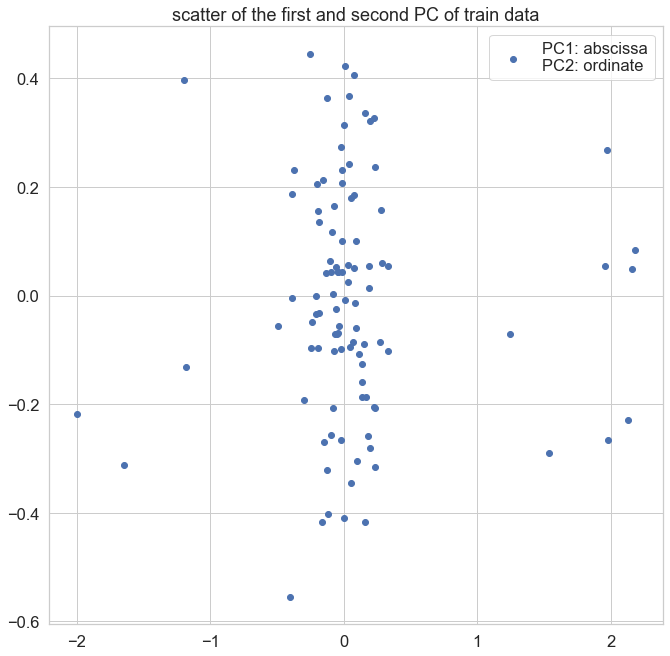

In [716]:
sns.set(font_scale=1.5, style="whitegrid")
plt.figure(figsize=(11, 11))
plot = plt.scatter(Us_reduced[:,0],Us_reduced[:,1])
plt.legend(["PC1: abscissa\nPC2: ordinate"])
_ = plt.title("scatter of the first and second PC of train data")

In [717]:
PC1 = Us_reduced[:, 0]
PC2 = Us_reduced[:, 1]
print("The mean values of the selected Primary Components are", np.mean(PC1),"and", np.mean(PC2))
print("Their standard deviation:", np.std(PC1),"and", np.std(PC2))

The mean values of the selected Primary Components are 0.08305489424395124 and -0.012020246834449008
Their standard deviation: 0.6413267496639679 and 0.21619397469484716


    We notice from the PC1-to-PC2 plot that almost all points go in a straight upwards line, meaning that the eigen value of the PC1 is much greater than that of PC2. This also means that PC1 has greater variance (deviation) than PC2.

    By taking the 2d projection (covariation) of the selected components matrix, we notice indeed that lambda1 is ten times bigger than lambda2 (diagonal matrix)

In [718]:
Us_reduced.T.dot(Us_reduced)

array([[ 4.18198115e+01, -3.10862447e-15],
       [-3.10862447e-15,  4.68843210e+00]])

VERIFICATION:

In [719]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X_train_fitted)

sum(sum(pca.components_ - U_reduced.T))

-2.48820163420687e-14

___
### 6- PCA before OLS

#### first point

In [720]:
X_PCA = X_train_fitted.dot(U_reduced)
X_PCA_test = X_test_fitted.dot(U_reduced)

#### second point

In [721]:
PCA_lin_reg = linear_model.LinearRegression()
PCA_lin_reg.fit(X_PCA, y_train)

LinearRegression()

In [722]:
# extra:
y_pred = PCA_lin_reg.predict(X_PCA)
print('R^2 on train data =', det_coef(y_train, y_pred))
print('MSE on train data =', MSE(y_train, y_pred))

R^2 on train data = 0.43259596585947646
MSE on train data = 48.4042369860613


#### third point

In [723]:
y_pred = PCA_lin_reg.predict(X_PCA_test)
print('Determination coefficient on test data (using my function) R^2 =', det_coef(y_test, y_pred))
print("The Mean Squared Error on the test data is MSE =", MSE(y_test, y_pred))

print('\nVERIFICATION: R^2 using libraries = {:.6f}\n'.format(
    PCA_lin_reg.score(X_PCA_test, y_test)))

Determination coefficient on test data (using my function) R^2 = 0.2136906912613884
The Mean Squared Error on the test data is MSE = 64.24069635370321

VERIFICATION: R^2 using libraries = 0.213691



In [724]:
pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

,Actual,Predicted
329,22.6,28.520305
371,50.0,16.609073
219,23.0,23.632533
403,8.3,13.355424
78,21.2,23.344225
...,...,...
49,19.4,27.854698
498,21.2,21.866432
309,20.3,23.100764
124,18.8,21.857791


#### forth point

In [725]:
df_test["PCA_OLS"] = y_pred

___
### 7- The loadings Phi

In [726]:
loadingsMatrix = U.dot(np.sqrt(S))
Phi = np.abs(loadingsMatrix[:, :2])

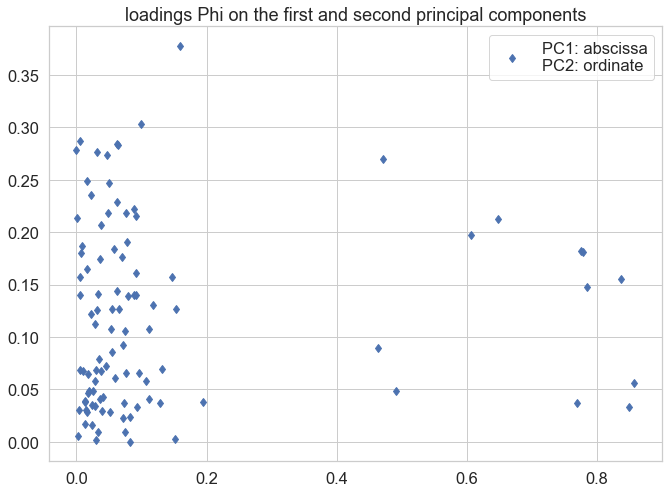

In [727]:
plt.figure(figsize=(11, 8))
plot = plt.plot(Phi[:,0], Phi[:,1], 'd')
plt.title("loadings Phi on the first and second principal components")
_ = plt.legend(["PC1: abscissa\nPC2: ordinate"])

    Loadings are the covariances between the original variables and the unit-scaled components.
    We see here that the loadings on the first PC are centralized towards 0 in relation to PC2. 

___
### 8- LASSO

#### first point

In [728]:
alpha = np.logspace(-3, 1, 30)
lasso_reg = LassoCV(alphas=alpha, n_alphas=30)
lasso_reg.fit(X_train_fitted, y_train)

LassoCV(alphas=array([1.00000000e-03, 1.37382380e-03, 1.88739182e-03, 2.59294380e-03,
       3.56224789e-03, 4.89390092e-03, 6.72335754e-03, 9.23670857e-03,
       1.26896100e-02, 1.74332882e-02, 2.39502662e-02, 3.29034456e-02,
       4.52035366e-02, 6.21016942e-02, 8.53167852e-02, 1.17210230e-01,
       1.61026203e-01, 2.21221629e-01, 3.03919538e-01, 4.17531894e-01,
       5.73615251e-01, 7.88046282e-01, 1.08263673e+00, 1.48735211e+00,
       2.04335972e+00, 2.80721620e+00, 3.85662042e+00, 5.29831691e+00,
       7.27895384e+00, 1.00000000e+01]),
        n_alphas=30)

In [729]:
# extra:
y_pred = lasso_reg.predict(X_train_fitted)
print('R^2 on train data =', det_coef(y_train, y_pred))
print('MSE on train data =', MSE(y_train, y_pred))

R^2 on train data = 0.7835614407800724
MSE on train data = 18.463991588061948


#### second point

In [730]:
y_pred = lasso_reg.predict(X_test_fitted)
print('Determination coefficient on test data (using my function) R^2 =', det_coef(y_test, y_pred))
print("The Mean Squared Error on the test data is MSE =", MSE(y_test, y_pred))

print('\nVERIFICATION: R^2 using libraries = {:.6f}\n'.format(
    lasso_reg.score(X_test_fitted, y_test)))

Determination coefficient on test data (using my function) R^2 = 0.5765330130478755
The Mean Squared Error on the test data is MSE = 34.596835904498036

VERIFICATION: R^2 using libraries = 0.576533



#### third point

In [731]:
print("The chosen regularization parameter (aplpha) by the LassoCrossValid algorithm was", lasso_reg.alpha_)
alpha_lasso = lasso_reg.alpha_
print("alpha =", alpha_lasso)

The chosen regularization parameter (aplpha) by the LassoCrossValid algorithm was 0.2212216291070448
alpha = 0.2212216291070448


In [732]:
#extra
print("\nWe have", sum(lasso_reg.coef_ != 0), "non-zero prediction coefficients, leaving us with",
      p - sum(lasso_reg.coef_ != 0), "sparse coefficients.")
pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})


We have 39 non-zero prediction coefficients, leaving us with 61 sparse coefficients.


,Actual,Predicted
329,22.6,27.468684
371,50.0,23.209801
219,23.0,28.565926
403,8.3,13.110860
78,21.2,21.686936
...,...,...
49,19.4,19.471645
498,21.2,20.769177
309,20.3,22.490341
124,18.8,17.298151


#### forth point

In [733]:
df_test["LASSO"] = y_pred

#### fifth point

In [734]:
df_coef["LASSO"] = [lasso_reg.intercept_] + list(lasso_reg.coef_)

___
### 9- Ridge

#### first point

In [744]:
alpha = np.logspace(-1, 2, 30)
ridge_reg = RidgeCV(alphas=alpha)
ridge_reg.fit(X_train_fitted, y_train)

RidgeCV(alphas=array([  0.1       ,   0.1268961 ,   0.1610262 ,   0.20433597,
         0.25929438,   0.32903446,   0.41753189,   0.52983169,
         0.67233575,   0.85316785,   1.08263673,   1.3738238 ,
         1.74332882,   2.21221629,   2.8072162 ,   3.56224789,
         4.52035366,   5.73615251,   7.27895384,   9.23670857,
        11.72102298,  14.87352107,  18.87391822,  23.9502662 ,
        30.39195382,  38.56620421,  48.93900918,  62.10169419,
        78.80462816, 100.        ]))

In [745]:
# extra:
y_pred = ridge_reg.predict(X_train_fitted)
print('R^2 on train data =', det_coef(y_train, y_pred))
print('MSE on train data =', MSE(y_train, y_pred))

R^2 on train data = 0.8152206953861048
MSE on train data = 15.763196439374443


#### second point

In [746]:
y_pred = ridge_reg.predict(X_test_fitted)
print('Determination coefficient on test data (using my function) R^2 =', det_coef(y_test, y_pred))
print("The Mean Squared Error on the test data is MSE =", MSE(y_test, y_pred))

print('\nVERIFICATION: R^2 using libraries = {:.6f}\n'.format(
    ridge_reg.score(X_test_fitted, y_test)))

Determination coefficient on test data (using my function) R^2 = 0.5355691501139859
The Mean Squared Error on the test data is MSE = 37.94354317473526

VERIFICATION: R^2 using libraries = 0.535569



#### third point

In [747]:
print("The chosen regularization parameter (aplpha) by the RidgeCrossValid algorithm was", ridge_reg.alpha_)
alpha_ridge = ridge_reg.alpha_
print("alpha =", alpha_ridge)

The chosen regularization parameter (aplpha) by the RidgeCrossValid algorithm was 48.93900918477494
alpha = 48.93900918477494


In [752]:
#extra
print("\nWe have", sum(ridge_reg.coef_ != 0), "non-zero prediction coefficients, leaving us with",
      p - sum(ridge_reg.coef_ != 0), "sparse coefficients.")
print("However, there are", sum(abs(ridge_reg.coef_) < 1e-1),
      "coefficients that are lesser than 0.1")
pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})


We have 100 non-zero prediction coefficients, leaving us with 0 sparse coefficients.
However, there are 25 coefficients that are lesser than 0.1


,Actual,Predicted
329,22.6,27.212810
371,50.0,22.909258
219,23.0,28.460453
403,8.3,11.977700
78,21.2,18.325560
...,...,...
49,19.4,20.434821
498,21.2,22.289282
309,20.3,21.396677
124,18.8,15.628586


#### forth point

In [749]:
df_test["Ridge"] = y_pred

#### fifth point

In [750]:
df_coef["Ridge"] = [ridge_reg.intercept_] + list(ridge_reg.coef_)

___
### 10- Forward Variable Selection FVS

In [754]:
def gram(X):
    n, _ = X.shape
    ones_n = np.ones(n).reshape(1,-1).T
    Xe = np.hstack((ones_n,X))
    return Xe.T.dot(Xe)/n

def sigma_hat(X, y, theta):
    n, p = X.shape
    ones_n = np.ones(n).reshape(1,-1).T
    Xe = np.hstack((ones_n,X))
    y_pred = Xe.dot(theta)
    return np.sqrt( np.sum((y - y_pred) ** 2) / (n - (p+1)))


def s_hat(X):
    inv_gram = np.linalg.inv(gram(X))
    
    return inv_gram[0,0]

def noEffectStat(X, y, theta):
    if X.shape[0] != y.size:
        raise ValueError('dimension mismatch')
    n, _ = X.shape
    s = s_hat(X)
    sigma = sigma_hat(X, y, theta)
    
    return np.abs(np.sqrt(n) * theta[1] / (s * sigma))

In [755]:
X = X_train_matrix_fitted
X_test = X_test_fitted
y = y_train

In [756]:
plotOn = False
selected = list()
candidates = list(range(p))

r = np.array(y)
while len(candidates):
    candidatesStat = dict()
    for i in range(p):
        if i in candidates:
            Xi = (X[:,i].reshape(-1, 1))
            OLSi = linear_model.LinearRegression()
            OLSi.fit(Xi, r)
            theta = np.array([OLSi.intercept_, OLSi.coef_[0]])
            candidatesStat[i] = noEffectStat(Xi, r, theta)
        else: candidatesStat[i] = 0
    if plotOn == True:
        plt.plot(candidatesStat.values(), '-')
        plt.pause(0.1)
    selectedCandidate = max(candidatesStat, key=candidatesStat.get)
    #print("selec. cand=", selectedCandidate)
    candidates.remove(selectedCandidate)
    selected = selected + [selectedCandidate]
    Xi = (X[:,selectedCandidate].reshape(-1, 1))
    OLSi = linear_model.LinearRegression()
    OLSi.fit(Xi, y)
    r = r - OLSi.predict(Xi)

In [757]:
print("The order of the selected variables is:\n", selected)

The order of the selected variables is:
 [44, 46, 29, 56, 34, 45, 27, 49, 78, 39, 23, 83, 47, 55, 52, 31, 24, 57, 89, 7, 76, 5, 79, 68, 4, 41, 3, 37, 35, 66, 6, 90, 8, 2, 92, 96, 82, 30, 74, 71, 40, 14, 93, 16, 36, 70, 65, 97, 19, 88, 59, 1, 69, 67, 62, 12, 53, 13, 38, 20, 28, 33, 80, 26, 10, 58, 86, 84, 63, 51, 21, 81, 32, 0, 87, 15, 48, 11, 43, 85, 18, 9, 42, 17, 64, 94, 99, 60, 54, 91, 22, 77, 98, 25, 61, 73, 75, 95, 50, 72]


In [758]:
covariates = X_train_fitted.columns
orderedCovariates = [0]*len(selected)
j=0
for i in selected:
    orderedCovariates[j] = covariates[i]
    j += 1
print("\nThe order of the selected covariates will be:\n", orderedCovariates)


The order of the selected covariates will be:
 ['X12', 'X10', 'X7', 'X6', 'X4', 'X2', 'X9', 'X8', 'X1', 'X0', 'X11', 'X5', 'X13', 'X61', 'X20', 'X71', 'X99', 'X86', 'X51', 'X27', 'X34', 'X69', 'X78', 'X60', 'X74', 'X30', 'X36', 'X62', 'X46', 'X55', 'X23', 'X94', 'X19', 'X52', 'X67', 'X35', 'X31', 'X59', 'X83', 'X92', 'X68', 'X81', 'X16', 'X73', 'X14', 'X97', 'X50', 'X87', 'X15', 'X47', 'X58', 'X95', 'X64', 'X91', 'X49', 'X21', 'X28', 'X75', 'X18', 'X90', 'X17', 'X57', 'X41', 'X80', 'X26', 'X54', 'X24', 'X88', 'X85', 'X44', 'X72', 'X40', 'X82', 'X76', 'X25', 'X29', 'X84', 'X63', 'X98', 'X70', 'X77', 'X39', 'X38', 'X22', 'X93', 'X37', 'X96', 'X33', 'X43', 'X45', 'X53', 'X48', 'X89', 'X32', 'X42', 'X65', 'X3', 'X56', 'X66', 'X79']


___
### 11- FVS with stopping condition

The p-value is the probability that the test statistic will be as extreme as or more extreme than the value we just got on our sample.

In [762]:
# initializations
plotOn = False   # set this to true to visualize the test sttatistic and the pvalues while processing the algorithm!         
stop = False
selected = list()
ordered = list()
candidates = list(range(p))
firstThreeStats = [0] * 3
firstThreePValueLists = [0] * 3
pValues = [0]*50
count3 = 0
count = 0

r = np.array(y)
pstop = 0.05
while (not stop or count < 50) and count < 50:
    candidatesStat = dict()
    pvaluesiter = dict()
    for i in range(p):
        if i in candidates:
            Xi = (X[:, i].reshape(-1, 1))
            OLSi = linear_model.LinearRegression()
            OLSi.fit(Xi, r)
            theta = np.array([OLSi.intercept_, OLSi.coef_[0]])
            statTest = noEffectStat(Xi, r, theta)
            candidatesStat[i] = statTest
            pvaluesiter[i] = 2 * (1 - norm(0, 1).cdf(statTest))
        else:
            candidatesStat[i] = 0
            pvaluesiter[i] = 1

    selectedCandidate = max(candidatesStat, key=candidatesStat.get)
    candidates.remove(selectedCandidate)
    
    if plotOn:
        plt.plot(candidatesStat.values(), '-')
        plt.plot(pvaluesiter.values(), '-')
        plt.pause(0.1)

    if pvaluesiter[selectedCandidate] > pstop:
        stop = True
    
    if not stop:
        selected = selected + [selectedCandidate]
    
    ordered = ordered + [selectedCandidate]
    
    Xi = (X[:, selectedCandidate].reshape(-1, 1))
    OLSi = linear_model.LinearRegression()
    OLSi.fit(Xi, y)
    r -= OLSi.predict(Xi)  # equivalent to :  r -=  OLSi.intercept_ + OLSiOLSi.coef_[0] * Xi

    pValues[count] = pvaluesiter
    if count3 < 3:
        firstThreeStats[count3] = candidatesStat
        firstThreePValueLists[count3] = pvaluesiter
        count3 += 1
            
    count += 1

    # print(np.sum(np.power(r, 2)))        # this line is to check the squared module of r

In [763]:
selected

[44, 46, 29, 56, 34, 45, 27, 49, 78, 39, 23, 83, 47, 55, 52, 31, 24, 57, 89]

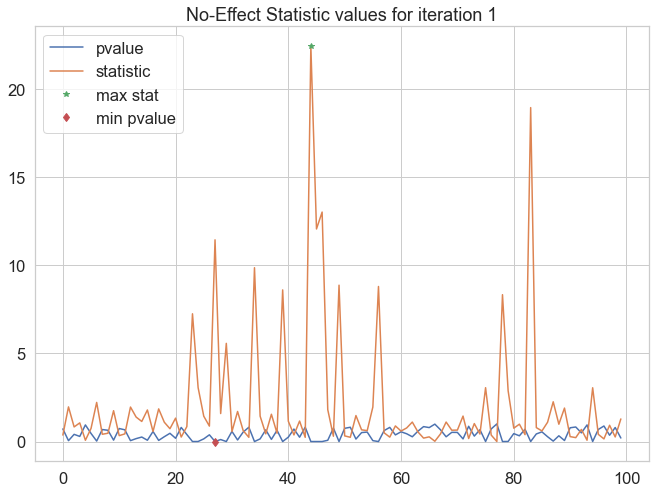

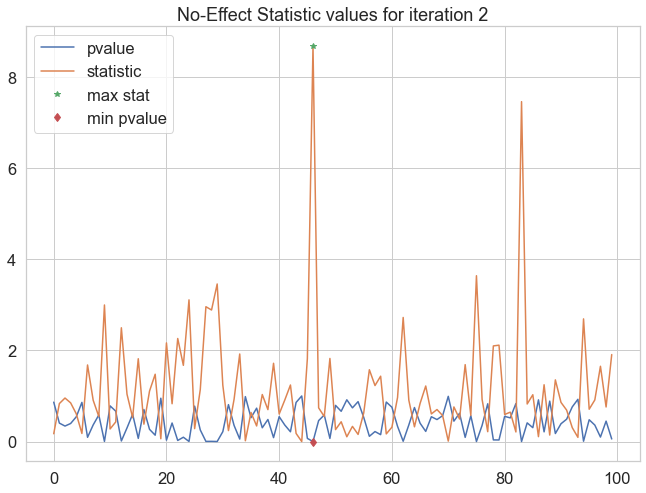

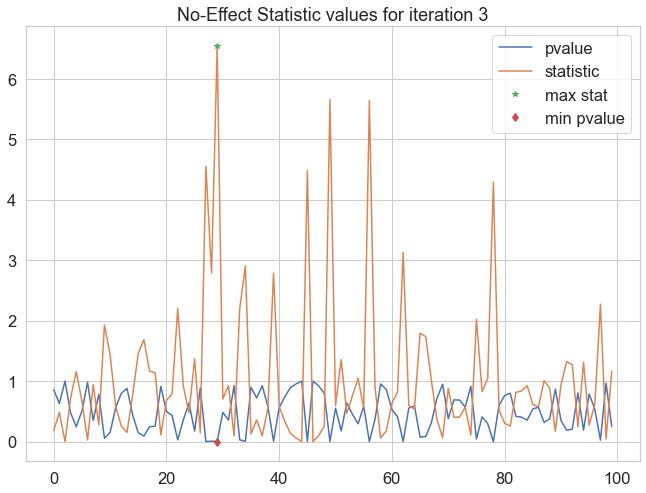

In [764]:
for i in range(3):
    bestpvalue = firstThreePValueLists[i]
    bestTest = firstThreeStats[i]
    plt.figure(figsize=(11, 8))
    
    plt.plot(bestpvalue.values())
    plt.plot(bestTest.values())
    plt.plot(max(bestTest, key=bestTest.get), max(bestTest.values()), 'g*')
    plt.plot(min(bestpvalue, key=bestpvalue.get), min(bestpvalue.values()), 'rd')
    plt.title("No-Effect Statistic values for iteration " + str(i+1))
    plt.legend(["pvalue", "statistic", "max stat", "min pvalue"])
    plt.pause(0.1)

    We note that we are also plotting the p-values of all covariates alongside with the test statistic.
    We also highlight the max Test Statistic value, alongside the min pvalue.

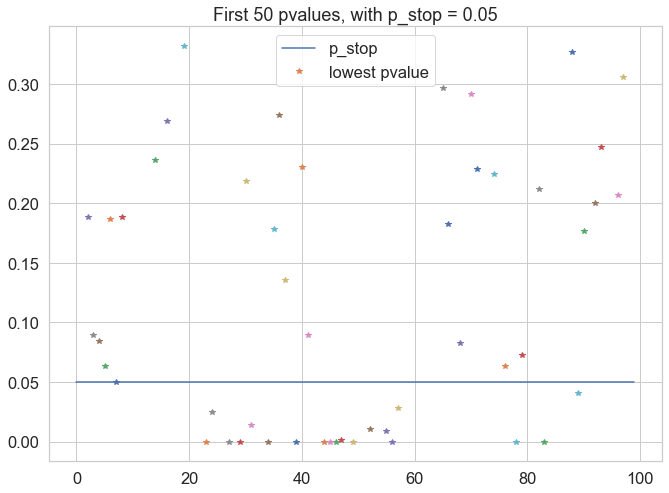

In [765]:
plt.figure(figsize=(11, 8))
plt.title("First 50 pvalues, with p_stop = 0.05")

span = np.array([float(i) for i in range(100)])
plt.plot(span, 0.05 * np.ones(100), '-')

i = 0
for iterationSpan in pValues:
    plt.plot(ordered[i], min(iterationSpan.values()), '*'); i+=1
plt.legend(["p_stop", "lowest pvalue"]) 

In [766]:
covariates = X_train_fitted.columns
selectedCovariates = [0]*len(selected)
j=0
for i in selected:
    selectedCovariates[j] = covariates[i]
    j += 1

print("Selected",len(selected),"covariates. The indexes of the oredered covariates are:\n", selected)    
print("\nThe order of the selected covariates will be:\n", selectedCovariates)

Selected 19 covariates. The indexes of the oredered covariates are:
 [44, 46, 29, 56, 34, 45, 27, 49, 78, 39, 23, 83, 47, 55, 52, 31, 24, 57, 89]

The order of the selected covariates will be:
 ['X12', 'X10', 'X7', 'X6', 'X4', 'X2', 'X9', 'X8', 'X1', 'X0', 'X11', 'X5', 'X13', 'X61', 'X20', 'X71', 'X99', 'X86', 'X51']


___
### 12- OLS with FVS

#### first point

In [769]:
X_FVS = X_train_fitted[selectedCovariates]
X_FVS_test = X_test_fitted[selectedCovariates]

OLS_FVS_reg = linear_model.LinearRegression()
OLS_FVS_reg.fit(X_FVS, y_train)

LinearRegression()

In [770]:
print("train score R2 =", OLS_FVS_reg.score(X_FVS, y_train))

train score R2 = 0.7699697785417892


#### second point

In [771]:
y_pred = OLS_FVS_reg.predict(X_FVS_test)
print('Determination coefficient on test data (using my function) R^2 =', det_coef(y_test, y_pred))
print("The Mean Squared Error on the test data is MSE =", MSE(y_test, y_pred))

Determination coefficient on test data (using my function) R^2 = 0.6243115153646224
The Mean Squared Error on the test data is MSE = 30.693379306116142


In [772]:
#extra
pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

,Actual,Predicted
329,22.6,26.392902
371,50.0,24.778377
219,23.0,28.061751
403,8.3,12.894709
78,21.2,22.018322
...,...,...
49,19.4,20.362524
498,21.2,21.937792
309,20.3,24.648787
124,18.8,22.607009


#### third point

In [824]:
df_test["FVS"] = y_pred

#### forth point

In [805]:
sparse = [0]*(p + 1 - len(OLS_FVS_reg.coef_)-1)
df_coef["FVS"] = [OLS_FVS_reg.intercept_] + list(OLS_FVS_reg.coef_) + sparse

___
### 13- Coefficients comparison

ZeroDivisionError: integer division or modulo by zero

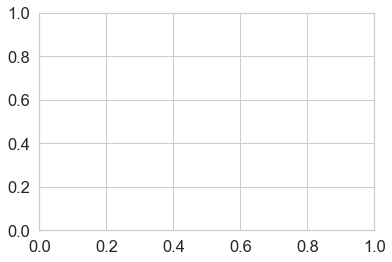

In [812]:
plt.plot(df_coef.values[:, :0])

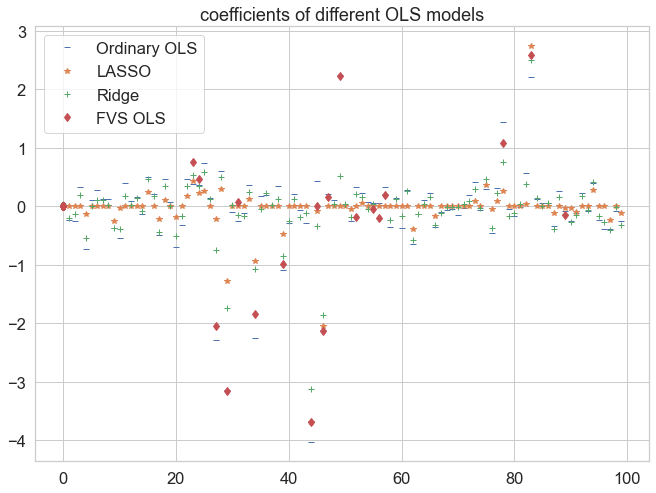

In [851]:
plt.figure(figsize=(11, 8))
plt.title("coefficients of different OLS models")
plt.plot(df_coef.values[1:, 0], '_')
plt.plot(df_coef.values[1:, 1], '*')
plt.plot(df_coef.values[1:, 2], '+')
plt.plot(selected + sparse, df_coef.values[1:, -1], 'd')
_ = plt.legend(["Ordinary OLS", "LASSO", "Ridge", "FVS OLS"])

    We notice that the coefficients vary from a model to another.
    
    The Ordinary OLS (OOLS) has its coefficients all scattered around 0, without them being much null.
    The LASSO and Ridge have a close distribution one to another. However they have lower amplitudes than those of the OOLS.
    
    The FVS model looks like he picks the coefficients that have the biggest value; 
    wherever there is a high value for a certain theta, we notice that covariate is selected by the Forward Variable Selection algorithm.

___
### 14- Coefficients comparison

In [862]:
zeros = dict()
for model in df_coef.columns:
    zeros[model] = sum(df_coef[model] == 0)
zeros["FVS"] -= len(sparse)

In [864]:
zeros

{'OLS': 0, 'LASSO': 61, 'Ridge': 0, 'FVS': 0}

    The ordinary OLS does not have any null coefficient.
    
    The Ridge does not have any null coef, but in contrast, LASSO has 61 null coefficient.
    This is due to the activation function using which the LASSO model is calculated. It improves sparsity of the system while reducing the amplitudes of the coefficients.
    
    For the Forward Variable Selection, our algorithm only chose 19 components for the chosen dataset, and none of the 19 coefficients is null!
    
    We should note too that the Ridge generates coefficients that are increasingly small in value, without them being null.

___
### 15- Coefficients comparison

Text(0.5, 1.02, 'pairplot of the prediction output for the different estimation models')

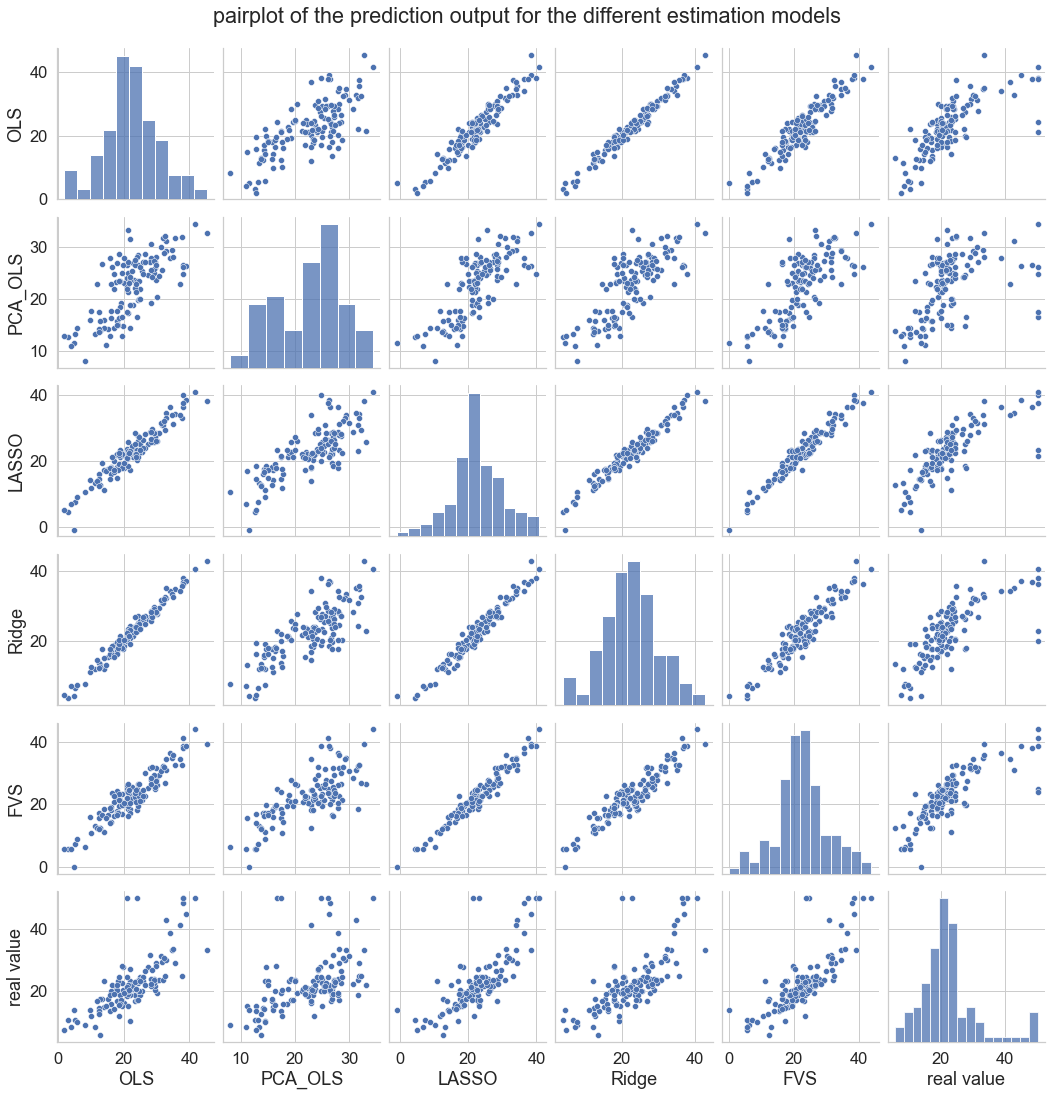

In [865]:
g = sns.pairplot(df_test)
g.fig.suptitle("pairplot of the prediction output for the different estimation models", y=1.02)

    We add the real output value to our dataset, and have a slight look at the closeness of each prediction to the actual values:

In [838]:
df_test["real value"] = list(y_test)
df_test

,OLS,PCA_OLS,LASSO,Ridge,FVS,real value
0,24.447577,28.520305,27.468684,27.212810,26.392902,22.6
1,24.219346,16.609073,23.209801,22.909258,24.778377,50.0
2,29.791327,23.632533,28.565926,28.460453,28.061751,23.0
3,11.284968,13.355424,13.110860,11.977700,12.894709,8.3
4,17.628549,23.344225,21.686936,18.325560,22.018322,21.2
...,...,...,...,...,...,...
122,20.223273,27.854698,19.471645,20.434821,20.362524,19.4
123,21.164997,21.866432,20.769177,22.289282,21.937792,21.2
124,21.715490,23.100764,22.490341,21.396677,24.648787,20.3
125,17.119596,21.857791,17.298151,15.628586,22.607009,18.8


We can now re-run the pairplot to get a fuller comparison about the models.

In [868]:
MSE(df_test["OLS"], y_test), MSE(df_test["PCA_OLS"], y_test),MSE(df_test["LASSO"], y_test), MSE(df_test["Ridge"], y_test), MSE(df_test["FVS"], y_test), MSE(df_test.mean(axis=1), y_test)

(17.000547071054115,
 9.006415123690145,
 16.053373238372654,
 14.693832564036903,
 17.550139422584483,
 13.396086960259906)

    We notice that a vector made of the average of all the predicted values generates a good looking MSE. Of course this tells us nothing regarding the determination coefficient.

___
The equation to predict the value of a new unseen data point x of p features will be:

We define $\hat{\theta}$ a vector of coefficients in $\mathbb{R}^{p}$, and since we did not center our outputs (the y vector), the equation will be:

$$ y_{pred}^{ols} = \bar{y} + x^T * \hat{\theta}^{ols} $$
$$ y_{pred}^{rd} = \bar{y} + x^T * \hat{\theta}^{rd} $$
$$ y_{pred}^{ls} = \bar{y} + x^T * \hat{\theta}^{ls} $$

For the PCA before OLS, we need to first project the point on our chosen principal components to get a denser look of that high dimensional point in 2-D:
$$ x_{proj} = x^T * U \in \mathbb{R}^2$$
$$ y_{pred}^{pca} = \bar{y} + x^T * \hat{\theta}^{pca}$$ 
where $\hat{\theta}^{pca}$ is in $\mathbb{R}^2$

And finally for the Forward Variable Selection, we need to just pick our selected covariates and throw away the rremaining data and proceed in the same usual matter. (a reduced dimension ordinary OLS)